Text classification problem using BERT Transformers

high level steps
Install & Import Libraries
Load and Pre-process the Data
Prepare PyTorch Dataset & Lightning DataModule
Define the Model (BERT based Classifier)
Train the Model using Lightning Trainer
Evaluate Performance of the Model
Model Inference

#a) Hugging Face Transformers 
(for BERT Model and Tokenizer), 
#b) PyTorch 
(DL framework & Dataset prep), 
c)PyTorch Lightning
(Model Definition and Training), 

d)Sklearn (for splitting dataset & metrics) 

In [1]:
import os
import re
import string
import numpy as np
import pandas as pd
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel, AdamW
import warnings
warnings.filterwarnings('ignore')

from collections import Counter


from tqdm.notebook import tqdm

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity

from scipy import sparse
from scipy.sparse.linalg import svds


from nltk.tokenize import sent_tokenize, word_tokenize, regexp_tokenize
from nltk.corpus import stopwords

import nltk
nltk.download('punkt')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns

from sklearn.preprocessing import MultiLabelBinarizer



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\upadh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df4model = pd.read_csv('../data/df4model.csv')

<Axes: >

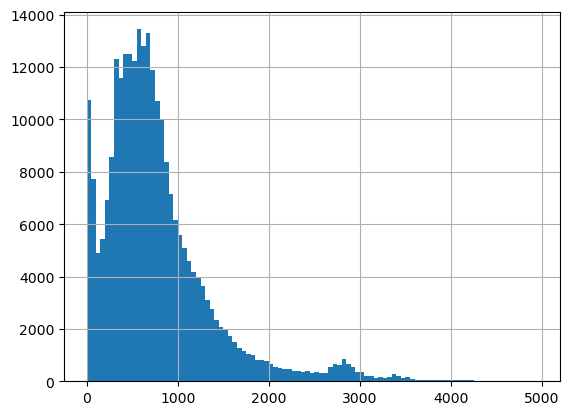

In [4]:
df4model['discharge_instruction'].str.len().hist(bins = np.arange(0,5000,50))

In [7]:
df4model['discharge_instruction'].values.tolist()

['Dear  , You were admitted for shortness of breath. You were found to have elevated blood pressure on admission in the setting of not taking all of your medications regularly. We obtained an echocargiogram of your heart which showed some strain on your heart possibly related to your elevated blood pressures.You will be contacted about an outpatient stress test. This will be completed within the next month.You will be prescribed several new medications as shown below. A visiting nurse  come to your home to help with managing your medications. You should dispose of all your home medications and only take the medications shown on this discharge paperwork.',
 'Dear  ,It was a pleasure caring for you at  . As you recall, you were admitted for shortness of breath. This was because one of your heart valves was weak, which caused fluid to build up in your lungs. Your heart valve was weak because there was a blockage in one of your heart arteries. You underwent a procedure, called cardiac cath

In [ ]:
#clean the text column to get rid of numbers, punctuation [^\w\s not a word or a sentence] and convert toe lower
# df4model['discharge_instruction'].replace("\d+", "").str.lower().str.replace(r'[^\w\s]+', '')

In [ ]:
#to fill in the value of the hot encoded columns to the alphabets

df.loc[df["gender"] == "male", "gender"] = 1

In [16]:
df4model.head()

,subject_id,hadm_id,icd,long_title,chief_complaint,surgical_invasive_procedure,history_present_illness,past_medcal_history,social_history,family_history,...,followup_instruction,icd_E11,icd_E78,icd_E87,icd_F32,icd_I16,icd_I50,icd_N17,icd_Y92,icd_Z85
0,10000980,29654838,I50,"Congestive heart failure, unspecified",Shortness of breath,None,"yo woman with h/o hypertension, hyperlipidemi...","1. CAD RISK FACTORS: +Diabetes, +Dyslipidemia,...",NaN,Denies cardiac family history. Family hx of DM...,...,NaN,1,1,0,0,0,1,0,0,0
1,10000980,26913865,I50,Acute on chronic systolic heart failure,dyspnea,Cardiac catheterization,"This is a M with history of diabetes, diastol...",hypertension diabetes hx CVA (cerebellarmedul...,NaN,"Niece had some sort of cancer. Otherwise, no f...",...,NaN,1,0,0,0,0,1,0,0,0
2,10000980,24947999,I50,Acute on chronic systolic heart failure,Dyspnea and chest tightness,Pharmacologic nuclear stress test,"year old female with history of HTN, HLD, hx ...",hypertension diabetes hx CVA (cerebellarm...,NaN,Niece had some sort of cancer. Father died in ...,...,NaN,1,1,0,0,0,1,0,0,0
3,10000980,25242409,I50,"Congestive heart failure, unspecified",DVT,EGD,This is a y/o female with PMHx significant fo...,hypertension diabetes hx CVA (cerebellarm...,NaN,Niece had some sort of cancer. Father died in ...,...,NaN,1,1,0,0,0,1,1,1,0
4,10000980,25911675,I50,Acute on chronic systolic (congestive) heart f...,"fatigue, anemia",None,is a year old woman with a past medical his...,hypertension diabetes hx CVA (cerebellarm...,NaN,Niece had some sort of cancer. Father died in ...,...,NaN,1,0,0,0,0,1,0,0,0


In [15]:
df4model.columns.tolist()

['subject_id',
 'hadm_id',
 'icd',
 'long_title',
 'chief_complaint',
 'surgical_invasive_procedure',
 'history_present_illness',
 'past_medcal_history',
 'social_history',
 'family_history',
 'physical_exam',
 'pertinent_results',
 'hospital_course',
 'medication_on_admission',
 'medication_on_discharge',
 'discharge_disposition',
 'discharge_diagnosis',
 'discharge_condition',
 'discharge_instruction',
 'followup_instruction',
 'icd_E11',
 'icd_E78',
 'icd_E87',
 'icd_F32',
 'icd_I16',
 'icd_I50',
 'icd_N17',
 'icd_Y92',
 'icd_Z85']

In [24]:
dfbert = df4model[['subject_id',
 'hadm_id','discharge_instruction',
 'icd_E11',
 'icd_E78',
 'icd_E87',
 'icd_F32',
 'icd_I16',
 'icd_I50',
 'icd_N17',
 'icd_Y92',
 'icd_Z85']]

In [25]:
#clean the text column to get rid of numbers, punctuation [^\w\s not a word or a sentence] and convert toe lower
dfbert['discharge_instruction'] = dfbert['discharge_instruction'].replace("\d+", "").str.lower().str.replace(r'[^\w\s]+', '')

In [26]:
dfbert

,subject_id,hadm_id,discharge_instruction,icd_E11,icd_E78,icd_E87,icd_F32,icd_I16,icd_I50,icd_N17,icd_Y92,icd_Z85
0,10000980,29654838,dear you were admitted for shortness of brea...,1,1,0,0,0,1,0,0,0
1,10000980,26913865,dear it was a pleasure caring for you at as...,1,0,0,0,0,1,0,0,0
2,10000980,24947999,dear were admitted to on with shortness of ...,1,1,0,0,0,1,0,0,0
3,10000980,25242409,dear it was a pleasure caring for you at you ...,1,1,0,0,0,1,1,1,0
4,10000980,25911675,dear it was a pleasure caring for you you were...,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
263936,19995832,23014132,dear why were you admitted to the hospital ...,0,0,0,0,0,0,0,0,1
263937,19997367,23127303,it was pleasure participating in your care whi...,0,0,0,0,0,0,0,0,1
263938,19997367,27185507,dear was a pleasure taking care of you during...,0,0,0,0,0,0,0,0,1
263939,19997576,25548363,dear it was a privilege taking care of you at...,0,0,0,0,0,0,0,0,1


In [29]:
#replace hostencoding with text
#'icd_E11',
#  'icd_E78',
#  'icd_E87',
#  'icd_F32',
#  'icd_I16',
#  'icd_I50',
#  'icd_N17',
#  'icd_Y92',
#  'icd_Z85'

map_dict = {1: "E11"}
map_dict1 = {1: "E78"}
map_dict2 = {1: "E87"}
map_dict3 = {1: "F32"}
map_dict4 = {1: "I16"}
map_dict5 = {1: "I50"}
map_dict6 = {1: "N17"}
map_dict7 = {1: "Y92"}
map_dict8 = {1: "Z85"}

dfbert["e11"] = dfbert["icd_E11"].map(map_dict)
dfbert["e78"] = dfbert["icd_E78"].map(map_dict1)
dfbert["e87"] = dfbert["icd_E87"].map(map_dict2)
dfbert["f32"] = dfbert["icd_F32"].map(map_dict3)
dfbert["i16"] = dfbert["icd_I16"].map(map_dict4)
dfbert["i50"] = dfbert["icd_I50"].map(map_dict5)
dfbert["n17"] = dfbert["icd_N17"].map(map_dict6)
dfbert["y92"] = dfbert["icd_Y92"].map(map_dict7)
dfbert["z85"] = dfbert["icd_Z85"].map(map_dict8)
dfbert

,subject_id,hadm_id,discharge_instruction,icd_E11,icd_E78,icd_E87,icd_F32,icd_I16,icd_I50,icd_N17,...,icd_Z85,e11,e78,e87,f32,i16,i50,n17,y92,z85
0,10000980,29654838,dear you were admitted for shortness of brea...,1,1,0,0,0,1,0,...,0,E11,E78,NaN,NaN,NaN,I50,NaN,NaN,NaN
1,10000980,26913865,dear it was a pleasure caring for you at as...,1,0,0,0,0,1,0,...,0,E11,NaN,NaN,NaN,NaN,I50,NaN,NaN,NaN
2,10000980,24947999,dear were admitted to on with shortness of ...,1,1,0,0,0,1,0,...,0,E11,E78,NaN,NaN,NaN,I50,NaN,NaN,NaN
3,10000980,25242409,dear it was a pleasure caring for you at you ...,1,1,0,0,0,1,1,...,0,E11,E78,NaN,NaN,NaN,I50,N17,Y92,NaN
4,10000980,25911675,dear it was a pleasure caring for you you were...,1,0,0,0,0,1,0,...,0,E11,NaN,NaN,NaN,NaN,I50,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263936,19995832,23014132,dear why were you admitted to the hospital ...,0,0,0,0,0,0,0,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Z85
263937,19997367,23127303,it was pleasure participating in your care whi...,0,0,0,0,0,0,0,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Z85
263938,19997367,27185507,dear was a pleasure taking care of you during...,0,0,0,0,0,0,0,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Z85
263939,19997576,25548363,dear it was a privilege taking care of you at...,0,0,0,0,0,0,0,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Z85


In [46]:
dfbert['icd']=(dfbert['e11'].astype(str)+','+dfbert['e78'].astype(str)+','
               +dfbert['e87'].astype(str)+','+dfbert['f32'].astype(str)+','+dfbert['i16'].astype(str)+','+
               dfbert['i50'].astype(str)+','+dfbert['n17'].astype(str)+','+dfbert['y92'].astype(str)+','+dfbert['z85'].astype(str))
dfbert['icd'] = dfbert['icd'].str.replace(',nan', '').str.replace(',', ', ')
dfbert.head()

,subject_id,hadm_id,discharge_instruction,icd_E11,icd_E78,icd_E87,icd_F32,icd_I16,icd_I50,icd_N17,...,e11,e78,e87,f32,i16,i50,n17,y92,z85,icd
0,10000980,29654838,dear you were admitted for shortness of brea...,1,1,0,0,0,1,0,...,E11,E78,NaN,NaN,NaN,I50,NaN,NaN,NaN,"E11, E78, I50"
1,10000980,26913865,dear it was a pleasure caring for you at as...,1,0,0,0,0,1,0,...,E11,NaN,NaN,NaN,NaN,I50,NaN,NaN,NaN,"E11, I50"
2,10000980,24947999,dear were admitted to on with shortness of ...,1,1,0,0,0,1,0,...,E11,E78,NaN,NaN,NaN,I50,NaN,NaN,NaN,"E11, E78, I50"
3,10000980,25242409,dear it was a pleasure caring for you at you ...,1,1,0,0,0,1,1,...,E11,E78,NaN,NaN,NaN,I50,N17,Y92,NaN,"E11, E78, I50, N17, Y92"
4,10000980,25911675,dear it was a pleasure caring for you you were...,1,0,0,0,0,1,0,...,E11,NaN,NaN,NaN,NaN,I50,NaN,NaN,NaN,"E11, I50"


In [ ]:
from datasets import Dataset
import evaluate
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import torch
from torchinfo import summary

In [ ]:
checkpoint = 'bert-base-uncased'
model_path = '../data/bert-based-uncased'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint, truncation_side='left', padding_side='left')

def tokenize_function(df):
    return tokenizer(df['text'], truncation=True, padding='max_length',  max_length=512)

acc = evaluate.load('accuracy')
precision = evaluate.load('precision')
recall = evaluate.load('recall')
f1 = evaluate.load('f1')
mcc = evaluate.load('matthews_correlation')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc_m = acc.compute(predictions=predictions, references=labels)
    precision_m = precision.compute(predictions=predictions, references=labels)
    recall_m = recall.compute(predictions=predictions, references=labels)
    f1_m = f1.compute(predictions=predictions, references=labels)
    mcc_m = mcc.compute(predictions=predictions, references=labels)
    metrics = {
        'accuracy': acc_m['accuracy'],
        'precision': precision_m['precision'],
        'recall': recall_m['recall'],
        'f1': f1_m['f1'],
        'mcc': mcc_m['matthews_correlation']
    }
    return metrics

In [ ]:
train_ds = Dataset.from_dict({'text': df['text'], 'labels': df['label']})
val_ds = Dataset.from_dict({'text': df['text'], 'labels': df['label']})

In [ ]:
tokenized_train_ds = train_ds.map(tokenize_function)
tokenized_train_ds = tokenized_train_ds.remove_columns(['text'])

tokenized_val_ds = val_ds.map(tokenize_function)
tokenized_val_ds = tokenized_val_ds.remove_columns(['text'])

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

In [ ]:
training_args = TrainingArguments(
    output_dir=model_path,
    evaluation_strategy='epoch',
    num_train_epochs=10,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    save_total_limit=10,
    save_strategy='epoch',
    load_best_model_at_end=True,
    log_level ='info',
    metric_for_best_model='eval_mcc',
    optim = 'adamw_torch',
    learning_rate=1e-05
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_val_ds,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [ ]:
test_results = trainer.predict(tokenized_test_ds)

In [ ]:
test_results.metrics